In [14]:
import pandas as pd
import sqlite3 as sql
import scipy.stats as stats

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
# DB file
db_file = '../sqlite_immigration_italienne.sqlite'


# create a connection
cn = sql.connect(db_file)


## Arrivées par genre

On prend toujours chaque personne une seule fois (cf. v_personne_avec_proprietes_agg) avec l'année du première enregistrement


In [6]:
query="""
SELECT SUBSTRING(min_date_permis,1,4) annee_arrivee, genre
FROM v_personne_avec_proprietes_agg
WHERE min_date_permis NOTNULL
ORDER BY annee_arrivee; 
"""

In [7]:
# Create a cursor
cur = cn.cursor()
cur.execute(query)
# La méthode 'fetchall' permet de récupérer toutes les lignes
r = cur.fetchall()

In [8]:
personnes = pd.DataFrame(r)
personnes.columns=['annee_arrivee', 'genre']
personnes.tail()

,annee_arrivee,genre
342,1870,homme
343,1870,homme
344,1870,homme
345,1870,homme
346,1870,homme


In [9]:


### Tableau de contingence
X = "annee_arrivee"
Y = "genre"  # "0"

ddf = personnes[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int).transpose()
ddf = ddf[:-1]
ddf



genre,femme,homme,Total
annee_arrivee,,,
1848,3,33,36
1849,8,28,36
1850,0,14,14
1851,5,8,13
1852,3,10,13
1853,1,18,19
1854,0,4,4
1855,1,4,5
1856,2,20,22


In [10]:
ddf['f_p'] = ddf.apply(lambda x : (x.femme/x.Total).round(1), axis=1)
ddf['h_p'] = ddf.apply(lambda x : (x.homme/x.Total).round(1), axis=1)
ddf

genre,femme,homme,Total,f_p,h_p
annee_arrivee,,,,,
1848,3,33,36,0.1,0.9
1849,8,28,36,0.2,0.8
1850,0,14,14,0.0,1.0
1851,5,8,13,0.4,0.6
1852,3,10,13,0.2,0.8
1853,1,18,19,0.1,0.9
1854,0,4,4,0.0,1.0
1855,1,4,5,0.2,0.8
1856,2,20,22,0.1,0.9


In [9]:
lp = ddf['h_p'].to_list()+ddf['f_p'].to_list()
print(lp[:3])

[0.9, 0.8, 1.0]


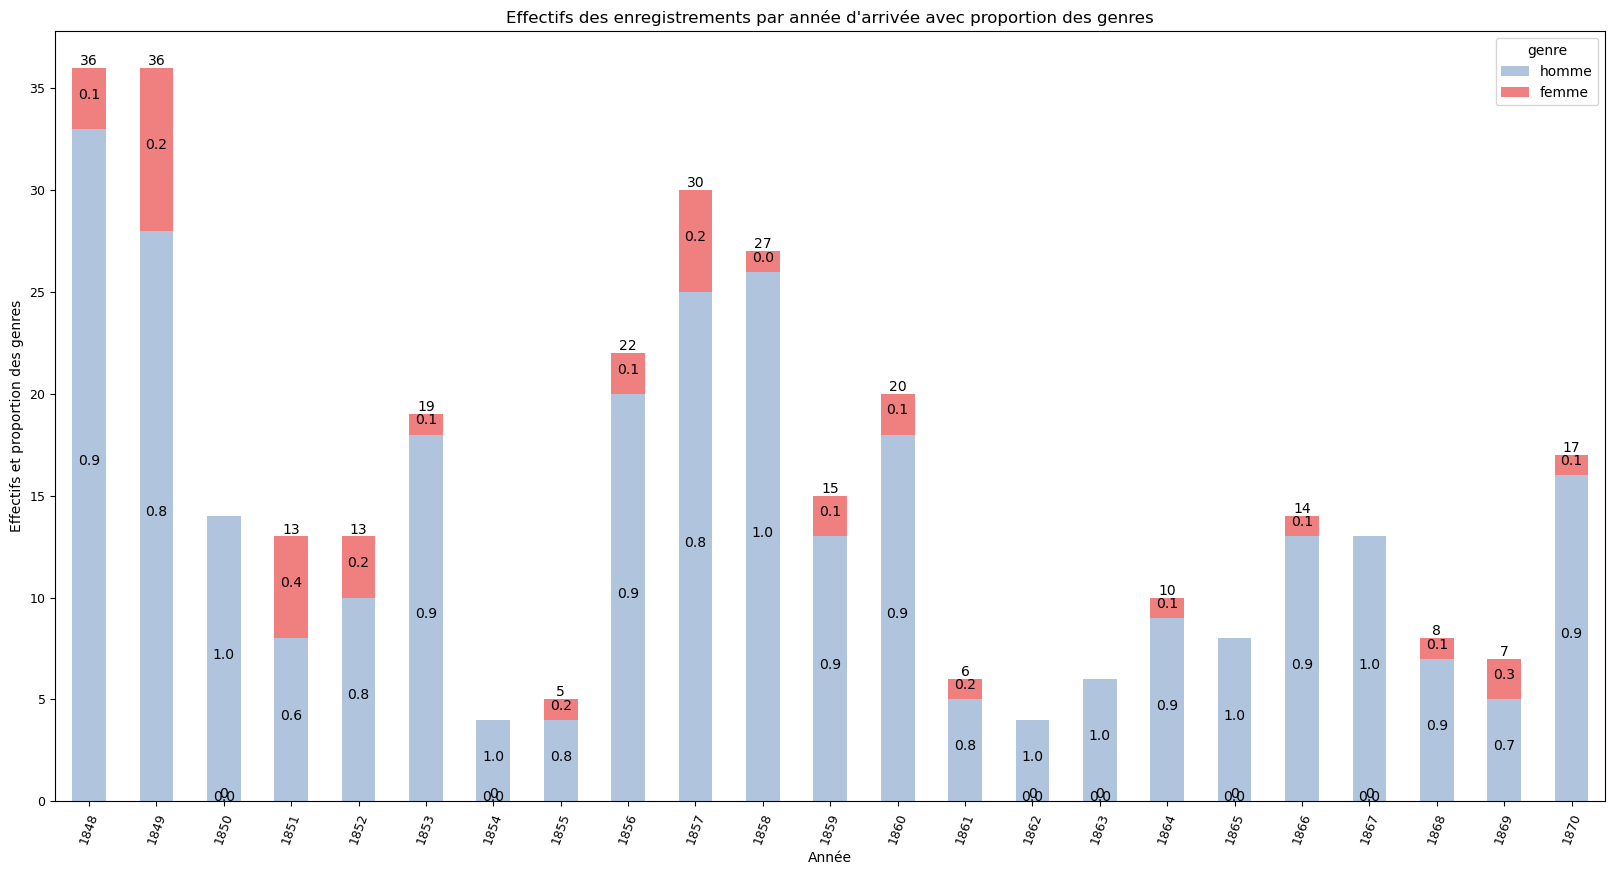

In [10]:
### Graphique avec la distribution par période et genre (M,F)
# Noter que les effectifs du genre 'Autres' étant très faibles,
# on ne les analyse pas de manière sérielle mais on peut les analyser qualitatiement


ax = ddf.plot.bar(stacked=True, y=['homme','femme'], \
                        rot=70, fontsize=9, figsize=(20,10), color=['LightSteelBlue', 'LightCoral'])


### https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/


## On ajoute une étiquette concernant la valeur de fréquence
# à chaque rectangle dans le graphe, en utilisant la list 'lp' préparée précédemment
# Il y a autant de triangles que les valeurs d'index x le nombre de variables
for bar,v in zip(ax.patches,lp): 

    ax.text(
      # Met les étiquette aux centre des rectangles
      bar.get_x() + bar.get_width() / 2,
        
      # Ajoute les coordonnées verticales
      bar.get_height()/2 + bar.get_y(), 
      
      # Ajoute les valeurs
      v,

      # centre et met du style aux étiquettes
      ha='center',
      color='black',
      #weight='bold',
      size=10
  )


ax.bar_label(ax.containers[-1])


plt.ylabel('Effectifs et proportion des genres')
plt.xlabel('Année')
plt.title("Effectifs des enregistrements par année d'arrivée avec proportion des genres")


# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('images/distribution_annee_genre.jpg', bbox_inches='tight',
                      pad_inches=0.2)
plt.show()

NOTE CONCERNANT LA PÉRIODISATION


De ce graphique apparaissent trois phases qu'on peut utilser pour la périodisation: 1848-1854, 1855-1860, 1861-1870.
  

### Genre - Période

In [11]:
def bivariee_stats(D):
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)


    # print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(D, method='cramer')
    print('Cramer: ', vc)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes

    fig, ax = plt.subplots(figsize=(9,3))         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

In [18]:
personnes['annee_arrivee'] = personnes['annee_arrivee'].astype(int)

In [23]:
lp = [1848, 1855, 1862, 1871]

personnes['periode'] = pd.cut(personnes['annee_arrivee'], lp, right=False)


personnes['periode'] = personnes['periode'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

print(personnes.head(), personnes.tail())


   annee_arrivee  genre    periode
0           1848  homme  1848-1854
1           1848  homme  1848-1854
2           1848  homme  1848-1854
3           1848  homme  1848-1854
4           1848  homme  1848-1854      annee_arrivee  genre    periode
342           1870  homme  1862-1870
343           1870  homme  1862-1870
344           1870  homme  1862-1870
345           1870  homme  1862-1870
346           1870  homme  1862-1870


In [25]:
### Tableau de contingence
X = "genre"
Y = "periode"  # "0"

ddf = personnes[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



genre,femme,homme,Total
periode,,,
1848-1854,20,115,135
1855-1861,14,111,125
1862-1870,6,81,87
Total,40,307,347


In [26]:
D = ddf.iloc[:3, :2].copy(deep=True)
D

genre,femme,homme
periode,,
1848-1854,20,115
1855-1861,14,111
1862-1870,6,81


Chi2 : 3.27 , dof : 2
p-value : 0.19465466779200316
Cramer:  0.09712074616624201


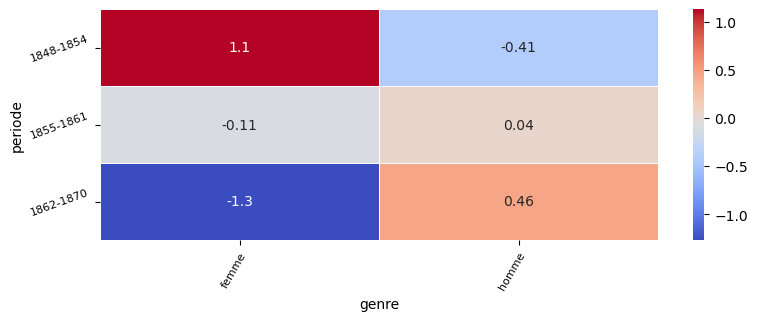

In [27]:
bivariee_stats(D)